# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import numpy as np
import pandas as pd
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

n_train = np.shape(X_train)[0]

n_test = np.shape(X_test)[0]

image_shape = np.shape(X_train)[1:4]

# Unique classes/labels there are in the dataset.
n_classes = len(pd.Series(y_train).value_counts())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

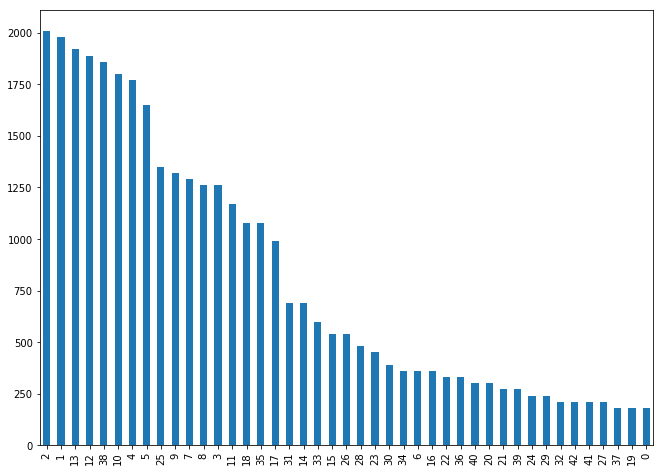

In [5]:
#Show class distribution
train_labels = pd.DataFrame(y_train,columns=['label'])
train_labels_cnts = train_labels['label'].value_counts()
train_labels_cnts.plot(kind='bar',figsize=(11, 8));

In [6]:
print("Largest Class is 2 with",len(X_train[y_train == 2]))
print("Smallest class is 0 wth",len(X_train[y_train == 0]))

Largest Class is 2 with 2010
Smallest class is 0 wth 180


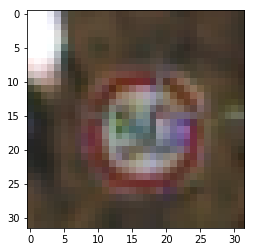

In [7]:
#Show a picture from class 2 (Speed limit (50km/h))
plt.imshow(X_train[y_train == 2][0])

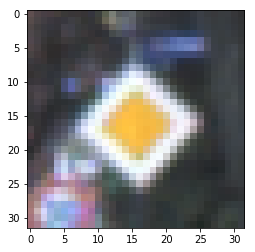

In [8]:
#Show a picture from class 12 (Priority road)
plt.imshow(X_train[y_train == 12][0])

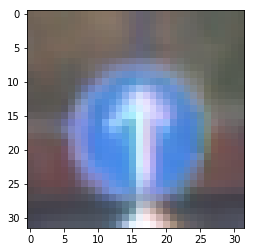

In [9]:
#Show a picture from class 35 (Ahead only)
plt.imshow(X_train[y_train == 35][0])

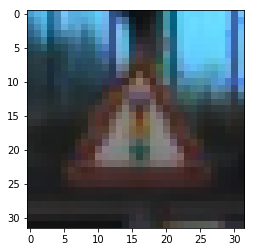

In [10]:
#Show a picture from class 26 (Traffic signals)
plt.imshow(X_train[y_train == 26][0])

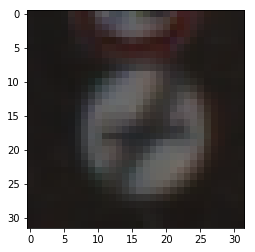

In [11]:
#Show a picture from class 41 (End of no passing)
plt.imshow(X_train[y_train == 41][0])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [12]:
import random
from sklearn.utils import shuffle
import math
import cv2

# Rotate image CW or CCW from 5 to 25 degrees
def rotate_image(img):
    rows,cols,chans = np.shape(img)
    ran_sample = [-5,-4,-3,-2,-1,1,2,3,4,5]
    
    colMid = cols/2
    rowMid = rows/2
    
    num = random.sample(ran_sample,1)[0]
    rotMat = cv2.getRotationMatrix2D((colMid,rowMid),(num*5),1)
    modImg = cv2.warpAffine(img,rotMat,(cols,rows))
    return modImg
 
# This function will normalize image to have pixel value between -1 and 1 
# Vectorized version
def normalize_image_set(imgSet):
    modImgSet = np.multiply(imgSet,(2/255))-1.
    return modImgSet

# Set pixel value to 0 for 20% of the image, should be used after normalization
def pixel_dropout(img):
    rows,cols,chans = np.shape(img)
    modImg = np.copy(img)
        
    ranX = random.sample(range(rows*cols), int(rows*cols*0.1))
    ranY = random.sample(range(rows*cols), int(rows*cols*0.1))

    modImg[np.mod(ranX,rows).ravel(),np.mod(ranY,cols).ravel()] = 0
    
    return modImg

# shrink image after normalization so image is padded with 0 not -1
def shrink_image(img):
    rows,cols,chans = np.shape(img)
    # create blank image of rows,cols because of shrinkage 
    modImg = np.zeros((rows,cols,chans))
    num = random.randint(0,1)
    scale = 0.9 if num == 0 else 0.8
    adj_r1 = int((rows-int(scale*rows))/2)
    adj_r2 = rows-int(scale*rows) - adj_r1

    adj_c1 = int((cols-int(scale*cols))/2)
    adj_c2 = cols-int(scale*cols) - adj_c1

    t_rz_img = cv2.resize(img,(int(scale*rows), int(scale*cols)), interpolation = cv2.INTER_AREA)
    modImg[adj_r1:rows-adj_r2, adj_c1:cols-adj_c2] += t_rz_img
    return modImg

def enlarg_image(img):
    rows,cols,chans = np.shape(img)
    # create blank image of rows,cols because of enlargment
    modImg = np.zeros((rows,cols,chans))
    num = random.randint(0,1)
    scale = 1.1 if num == 0 else 1.2
    adj_r = int((int(scale*rows)-rows)/2)

    adj_c = int((int(scale*cols)-cols)/2)

    t_rz_img = cv2.resize(img,(int(scale*rows), int(scale*cols)))
    
    modImg += t_rz_img[adj_r:adj_r+rows, adj_c:adj_c+cols]
    return modImg

def shift_image(img):
    rows,cols,chans = np.shape(img)
    ran_sample = [-10,-5,5,10]
    
    colShf = random.sample(ran_sample, 1)[0]
    rowShf = random.sample(ran_sample, 1)[0]
    
    M = np.float32([[1,0,colShf],[0,1,rowShf]])
    
    #shift with 0
    modImg = cv2.warpAffine(img,M,(cols,rows))
    return modImg

# Generate modified image based randomly selected image of image set
def generate_mod_image_set(imgSet, cnt): 
    modImgSet = np.array([])
    sample,rows,cols,chans = np.shape(imgSet)
    for i in range(cnt):
        #choose randome iamge
        img_idx = random.randint(0,sample-1)
        choice = random.randint(0,4)
        if choice == 0:
            modImg = rotate_image(imgSet[img_idx])
        elif choice == 1:
            modImg = pixel_dropout(imgSet[img_idx])
        elif choice == 2:
            modImg = shrink_image(imgSet[img_idx])
        elif choice == 3:
            modImg = enlarg_image(imgSet[img_idx])
        else:
            modImg = shift_image(imgSet[img_idx])
        
        modImgSet = np.append(modImgSet,modImg)
        
    #reshape modImgSet                
    modImgSet = np.reshape(modImgSet,(cnt,rows,cols,chans))
    return modImgSet

# Generate copy of iamges to balance out class set
def generate_cpy_image_set(imgSet, cnt):
    modImgSet = np.array([])
    sample,rows,cols,chans = np.shape(imgSet)
    full_cpys = math.floor(cnt/float(sample))
    if full_cpys > 0 and cnt%sample == 0:
        for i in range(full_cpys):
            modImgSet = np.append(modImgSet,imgSet)
    elif full_cpys > 0 and cnt%sample != 0:
        for i in range(full_cpys):
            modImgSet = np.append(modImgSet,imgSet)
        for j in range(int(cnt-(full_cpys*sample))):
            img_idx = random.randint(0,sample-1)
            modImgSet = np.append(modImgSet,imgSet[img_idx])
    else:
        for i in range(cnt):
            img_idx = random.randint(0,sample-1)
            modImgSet = np.append(modImgSet,imgSet[img_idx])
            
    #reshape modImgSet                
    modImgSet = np.reshape(modImgSet,(cnt,rows,cols,chans))
    return modImgSet       

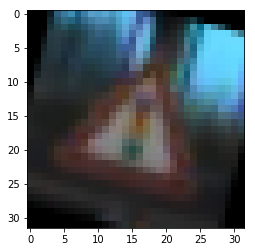

In [13]:
#Example Usage of rotate_image
test_img = X_train[y_train == 26][0]
plt.imshow(rotate_image(test_img))

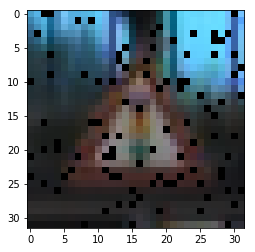

In [14]:
#Example Usage of pixel_dropout
plt.imshow(pixel_dropout(test_img))

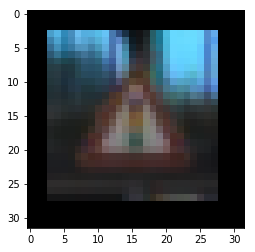

In [15]:
#Example of shrink
plt.imshow(np.uint8(shrink_image(test_img)))

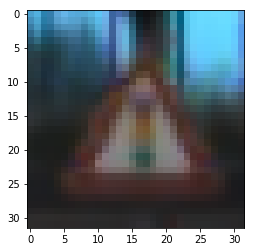

In [16]:
#Example of enlarge
plt.imshow(np.uint8(enlarg_image(test_img)))

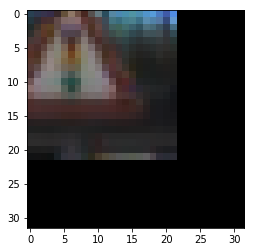

In [17]:
#Example of shift
plt.imshow(np.uint8(shift_image(test_img)))

In [17]:
#normalize first
X_train_norm = normalize_image_set(X_train)

#shuffle iamge set
X_train_norm, y_train_norm = shuffle(X_train_norm, y_train)

In [18]:
#make sure every class has 2010 images
tx_train_mod = ty_train_mod = np.array([])
for cla in range(n_classes):
    c_img_set = X_train_norm[y_train_norm == cla]
    tx_train_mod = np.append(tx_train_mod,generate_cpy_image_set(c_img_set,2010))
    ty_train_mod = np.append(ty_train_mod,[cla]*2010)

In [19]:
#reshape
rows,cols,chans = np.shape(test_img)
tx_train_mod = np.reshape(tx_train_mod,(len(ty_train_mod),rows,cols,chans)) 

In [20]:
#verify classes all have 2010 images
ty_train_mod_df = pd.DataFrame(ty_train_mod,columns=['label'])
ty_train_mod_df = ty_train_mod_df['label'].value_counts()
ty_train_mod_df

15.0    2010
22.0    2010
35.0    2010
26.0    2010
34.0    2010
41.0    2010
24.0    2010
20.0    2010
3.0     2010
17.0    2010
29.0    2010
40.0    2010
10.0    2010
33.0    2010
18.0    2010
25.0    2010
32.0    2010
8.0     2010
4.0     2010
2.0     2010
14.0    2010
42.0    2010
21.0    2010
11.0    2010
7.0     2010
39.0    2010
38.0    2010
13.0    2010
28.0    2010
6.0     2010
19.0    2010
31.0    2010
5.0     2010
30.0    2010
37.0    2010
27.0    2010
36.0    2010
16.0    2010
12.0    2010
1.0     2010
9.0     2010
23.0    2010
0.0     2010
Name: label, dtype: int64

In [21]:
# Construct modified training set
# Review:
# 1) Normalize
# 2) Generate copies so each class has 2010 iamges
# 3) Now modify 35% of the images to be either rotated,pixel dropout,shrink,enlarge
tx_train_mod, ty_train_mod = shuffle(tx_train_mod, ty_train_mod)
X_train_mod = y_train_mod = np.array([])
idx_35 = int(0.35*2010)
for cla in range(n_classes):
    c_img_set = tx_train_mod[ty_train_mod == cla]
    X_train_mod = np.append(X_train_mod,generate_mod_image_set(c_img_set,idx_35))
    X_train_mod = np.append(X_train_mod,c_img_set[idx_35:])
    y_train_mod = np.append(y_train_mod,[cla]*2010)

In [22]:
#Reshape x_train_mod
rows,cols,chans = np.shape(test_img)
X_train_mod = np.reshape(X_train_mod,(len(y_train_mod),rows,cols,chans)) 

In [23]:
#Verify each class still has 2010 images
y_train_mod_df = pd.DataFrame(y_train_mod,columns=['label'])
y_train_mod_df = y_train_mod_df['label'].value_counts()
y_train_mod_df

15.0    2010
22.0    2010
35.0    2010
26.0    2010
34.0    2010
41.0    2010
24.0    2010
20.0    2010
3.0     2010
17.0    2010
29.0    2010
40.0    2010
10.0    2010
33.0    2010
18.0    2010
25.0    2010
32.0    2010
8.0     2010
4.0     2010
2.0     2010
14.0    2010
42.0    2010
21.0    2010
11.0    2010
7.0     2010
39.0    2010
38.0    2010
13.0    2010
28.0    2010
6.0     2010
19.0    2010
31.0    2010
5.0     2010
30.0    2010
37.0    2010
27.0    2010
36.0    2010
16.0    2010
12.0    2010
1.0     2010
9.0     2010
23.0    2010
0.0     2010
Name: label, dtype: int64

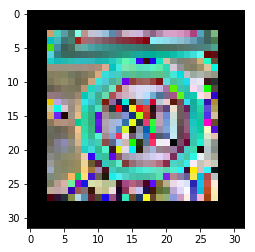

In [24]:
#Take a look at an image to make sure class and modification worked
plt.imshow(X_train_mod[y_train_mod==0][500])

In [25]:
#Save data set at pickle binary
training_file_mod = "traffic-signs-data/train_mod.p"
pickle.dump({'train_data':X_train_mod ,'label':y_train_mod}, open(training_file_mod,"wb"))

In [18]:
# Load training data with modified iamges
training_file_mod = "traffic-signs-data/train_mod.p"
with open(training_file_mod, mode='rb') as f:
    train2 = pickle.load(f)
 
X_train_mod, y_train_mod = train2['train_data'], train2['label']

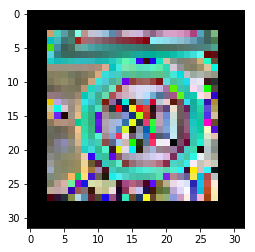

In [19]:
#Take a look at an image to make sure class and modification worked
plt.imshow(X_train_mod[y_train_mod==0][500])

### Model Architecture

In [20]:
import tensorflow as tf
print(tf.__version__)
from sklearn.utils import shuffle

1.0.0


#### Final Model
Overview: The model started from a quest to learn about inception. IncepRes is mainly based on Google's Inception-ResNet-v2 that produced the best result on ILSVRC 2012 in a publication (https://arxiv.org/pdf/1602.07261.pdf). Output shape are specified like (17x17x20) 

<figure>
 <figcaption>
 <p></p> 
 <p style="text-align: center; bold"> <b>IncepRes Architecture</b></p> 
 </figcaption>
 <img src="IncepRes.png" width="380" height="600" alt="IncepRes Architecture" />
</figure>
 <p></p> 

Next to layer name; filter size (e.g. 3x3), stride (e.g. S1) and padding (e.g. V) are displayed. The picture below describes the "Stem" of the architecture. The purpose of the stem is to reduce the size of image from 32x32 to 17x17. I arbitrarily choose a depth of 20 layers (4 more than LeNet). I used convolution and max pooling layers without relu activation to reduce the size.

<figure>
 <figcaption>
 <p></p> 
 <p style="text-align: center; bold"> <b>Stem Sub-Architecture</b></p> 
 </figcaption>
 <img src="Stem.png" width="280" alt="Stem Sub-Architecture" />
</figure>
 <p></p>
 
Next is Inception-ResNet-B from Google's Inception-ResNet-v2. Evey layer have same padding to output the same shape as input (17x17x20). The graph does not explicit show filter concatination when convolution branch merge, however, that is what I did. The paper also explain that residual (convolution layers) should be scaled between 0.1 and 0.3 before adding back to identity. I scaled the last 1x1 convolution layer with Batch Normalization with scaling of 0.3.

<figure>
 <figcaption>
 <p></p> 
 <p style="text-align: center; bold"> <b>Inception-ResNet-B Sub-Architecture</b></p> 
 </figcaption>
 <img src="Inception-ResNet-B.png" width="280" alt="Inception-ResNet-B Sub-Architecture" />
</figure>
 <p></p>

Then I used modified Reduction-B to reduce 17x17x20 down to 8x8x84. The depth of convolution consist of 3 layers of 20 deep and 1 layer of 24 deep. 

<figure>
 <figcaption>
 <p></p> 
 <p style="text-align: center; bold"> <b>Reduction-B Sub-Architecture</b></p> 
 </figcaption>
 <img src="Reduction-B.png" width="280" alt="Reduction-B Sub-Architecture" />
</figure>
 <p></p>
 
Since 84 was similar to the number of Fully Connected nodes at the end of LeNet, The last part of the architecture further reduce 8x8x84 to 1x1x84. I tested with dropout and keep probability of 0.8, 0.9, and 1.0. Dropout with keep probability of 0.9 produced the best results.

I also test with adding 3 more Inception-ResNet-C (IncepRes_V1), with size 3x3x84, after reducing 8x8x84 to 3x3x84. The resulting validation accuracy was much less compared to final model.  


In [21]:
from tensorflow.contrib.layers import flatten

def stemBlock(x,mu=0.,sigma=0.1):
    # This stem reduce dimension from 32x32x3 to 17x17x20
    # filter weights: (height, width, input_depth, output_depth)
        
    # for valid padding:
    # out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
    # out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
    # stride: (batch (1),height,width,channel (1))
    
    l_stride = [1,1,1,1]
    
    # ***************************   Layer 1  **********************************************************************
    # Convolutional. Input = 32x32x3. Output = 28x28x8.
    l1_conv_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,8),mean=mu,stddev=sigma))
    l1_conv_b = tf.Variable(tf.zeros(8))
    l1_conv_a = tf.nn.conv2d(x,l1_conv_W,strides=l_stride,padding='VALID') + l1_conv_b
    
    # ***************************   Layer 2  **********************************************************************
    # Convolutional. Input = 28x28x8. Output = 24x24x8.
    l2_conv_W = tf.Variable(tf.truncated_normal(shape=(5,5,8,8),mean=mu,stddev=sigma))
    l2_conv_b = tf.Variable(tf.zeros(8))
    l2_conv_a = tf.nn.conv2d(l1_conv_a,l2_conv_W,strides=l_stride,padding='VALID') + l2_conv_b
    
    # ***************************   Layer 3  **********************************************************************
    # Max Pool. Input = 24x24x8. Output = 22x22x8.
    # new_height = (input_height - filter_height)/S + 1
    # new_width = (input_width - filter_width)/S + 1
    l3_pool_a = tf.nn.max_pool(l2_conv_a,ksize=[1,3,3,1],strides=l_stride,padding='VALID')
    
    # ***************************   Layer 4  **********************************************************************
    # Convolutional. Input = 22x22x8. Output = 20x20x20.
    l4_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,8,20),mean=mu,stddev=sigma))
    l4_conv_b = tf.Variable(tf.zeros(20))
    l4_conv_a = tf.nn.conv2d(l3_pool_a,l4_conv_W,strides=l_stride,padding='VALID') + l4_conv_b
    
    # ***************************   Layer 5  **********************************************************************
    # Convolutional. Input = 20x20x20. Output = 18x18x20.
    l5_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,20),mean=mu,stddev=sigma))
    l5_conv_b = tf.Variable(tf.zeros(20))
    l5_conv_a = tf.nn.conv2d(l4_conv_a,l5_conv_W,strides=l_stride,padding='VALID') + l5_conv_b
    
    # ***************************   Layer 6  **********************************************************************
    # Max Pool. Input = 18x18x20. Output = 17x17x20.
    # new_height = (input_height - filter_height)/S + 1
    # new_width = (input_width - filter_width)/S + 1
    a_stem = tf.nn.max_pool(l5_conv_a,ksize=[1,2,2,1],strides=l_stride,padding='VALID')
    return a_stem

# This is called after stemBlock. Input = 17x17x20. Output = 17x17x20
def subIncepResB(x,mu=0.,sigma=0.1,scale=0.3,mode='TRAIN'):
    l_stride = [1,1,1,1]
    
    # ***************************   Layer 1  **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 17x17x20. 1x1 convolution
    l1_conv_W = tf.Variable(tf.truncated_normal(shape=(1,1,20,20),mean=mu,stddev=sigma))
    l1_conv_b = tf.Variable(tf.zeros(20))
    l1_conv_a = tf.nn.conv2d(x,l1_conv_W,strides=l_stride,padding='SAME') + l1_conv_b
    
    # ***************************   Layer 1a **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 17x17x20. 
    l1a_conv_W = tf.Variable(tf.truncated_normal(shape=(1,7,20,20),mean=mu,stddev=sigma))
    l1a_conv_b = tf.Variable(tf.zeros(20))
    l1a_conv_a = tf.nn.conv2d(l1_conv_a,l1a_conv_W,strides=l_stride,padding='SAME') + l1a_conv_b
    
    # ***************************   Layer 1b **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 17x17x20.  
    l1b_conv_W = tf.Variable(tf.truncated_normal(shape=(7,1,20,20),mean=mu,stddev=sigma))
    l1b_conv_b = tf.Variable(tf.zeros(20))
    l1b_conv_a = tf.nn.conv2d(l1a_conv_a,l1b_conv_W,strides=l_stride,padding='SAME') + l1b_conv_b
    
    # ***************************   Layer 2  **********************************************************************
    # Concatinate. Output = 17x17x40
    l2_concat_a = tf.concat([l1_conv_a, l1b_conv_a], axis=3)
    
    # ***************************   Layer 3  **********************************************************************
    # Convolutional. Input = 17x17x40. Output = 17x17x20. 1x1 convolution
    l3_conv_W = tf.Variable(tf.truncated_normal(shape=(1,1,40,20),mean=mu,stddev=sigma))
    l3_conv_b = tf.Variable(tf.zeros(20))
    l3_conv_a = tf.nn.conv2d(l2_concat_a,l3_conv_W,strides=l_stride,padding='SAME') + l3_conv_b
    
    # Scale Layer 3 Use Batch Normalization with scaling if in training mode
    # Have to normalize or validation accuracy is low
    # Per documentation: For so-called "global normalization", 
    # used with convolutional filters with shape [batch, height, width, depth], pass axes=[0, 1, 2].
    a_mu,a_var = tf.nn.moments(l3_conv_a,axes=[0, 1, 2]) # calculate for batch normalization
    # Variance epsilon: A small float number to avoid dividing by 0.
    res_bn_a = tf.nn.batch_normalization(l3_conv_a,mean=a_mu,variance=a_var,offset=None,scale=scale,variance_epsilon=0.0001)
    res_a = res_bn_a
    
    # Add residule to identity
    res_a = tf.add(x,res_a)
    
    # Activation
    res_z = tf.nn.relu(res_a)
    
    return res_z

# Input = 3x3x84. Output = 3x3x84
def subIncepResC(x,mu=0.,sigma=0.1,scale=0.3,mode='TRAIN'):
    l_stride = [1,1,1,1]
    
    # ***************************   Layer 1  **********************************************************************
    # Convolutional. Input = 3x3x84. Output = 3x3x84. 1x1 convolution
    l1_conv_W = tf.Variable(tf.truncated_normal(shape=(1,1,84,84),mean=mu,stddev=sigma))
    l1_conv_b = tf.Variable(tf.zeros(84))
    l1_conv_a = tf.nn.conv2d(x,l1_conv_W,strides=l_stride,padding='SAME') + l1_conv_b
    
    # ***************************   Layer 1a **********************************************************************
    # Convolutional. Input = 3x3x84. Output = 3x3x84. 
    l1a_conv_W = tf.Variable(tf.truncated_normal(shape=(1,3,84,84),mean=mu,stddev=sigma))
    l1a_conv_b = tf.Variable(tf.zeros(84))
    l1a_conv_a = tf.nn.conv2d(l1_conv_a,l1a_conv_W,strides=l_stride,padding='SAME') + l1a_conv_b
    
    # ***************************   Layer 1b **********************************************************************
    # Convolutional. Input = 3x3x84. Output = 3x3x84.  
    l1b_conv_W = tf.Variable(tf.truncated_normal(shape=(3,1,84,84),mean=mu,stddev=sigma))
    l1b_conv_b = tf.Variable(tf.zeros(84))
    l1b_conv_a = tf.nn.conv2d(l1a_conv_a,l1b_conv_W,strides=l_stride,padding='SAME') + l1b_conv_b
    
    # ***************************   Layer 2  **********************************************************************
    # Concatinate. Output = 3x3x168
    l2_concat_a = tf.concat([l1_conv_a, l1b_conv_a], axis=3)
    
    # ***************************   Layer 3  **********************************************************************
    # Convolutional. Input = 3x3x168. Output = 3x3x84. 1x1 convolution
    l3_conv_W = tf.Variable(tf.truncated_normal(shape=(1,1,168,84),mean=mu,stddev=sigma))
    l3_conv_b = tf.Variable(tf.zeros(84))
    l3_conv_a = tf.nn.conv2d(l2_concat_a,l3_conv_W,strides=l_stride,padding='SAME') + l3_conv_b
    
    # Scale Layer 3 Use Batch Normalization with scaling
    # Have to normalize or validation accuracy is low
    # Per documentation: For so-called "global normalization", 
    # used with convolutional filters with shape [batch, height, width, depth], pass axes=[0, 1, 2].
    a_mu,a_var = tf.nn.moments(l3_conv_a,axes=[0, 1, 2]) # calculate for batch normalization
    # Variance epsilon: A small float number to avoid dividing by 0.
    res_bn_a = tf.nn.batch_normalization(l3_conv_a,mean=a_mu,variance=a_var,offset=None,scale=scale,variance_epsilon=0.0001)
    res_a = res_bn_a
  
    # Add residule to identity
    res_a = tf.add(x,res_a)
    
    # Activation
    res_z = tf.nn.relu(res_a)
    
    return res_z

# This is called after subIncepResB. Reduce 17x17x20 to 8x8x84
def reduction(x,mu=0.,sigma=0.1):
    l_stride1 = [1,1,1,1]
    l_stride2 = [1,2,2,1]
    
    # ***************************   Branch 1  **********************************************************************
    # Max Pool. Input = 17x17x20. Output = 8x8x20. 
    b1_pool_a = tf.nn.max_pool(x,ksize=[1,3,3,1],strides=l_stride2,padding='VALID')
    
    # ***************************   Branch 2  **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 17x17x20. 1x1 convolution
    b2_conv_W = tf.Variable(tf.truncated_normal(shape=(1,1,20,20),mean=mu,stddev=sigma))
    b2_conv_b = tf.Variable(tf.zeros(20))
    b2_conv_a = tf.nn.conv2d(x,b2_conv_W,strides=l_stride1,padding='SAME') + b2_conv_b
    
    # ***************************   Branch 2a **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 8x8x24. 
    b2a_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,24),mean=mu,stddev=sigma))
    b2a_conv_b = tf.Variable(tf.zeros(24))
    b2a_conv_a = tf.nn.conv2d(b2_conv_a,b2a_conv_W,strides=l_stride2,padding='VALID') + b2a_conv_b
    
    # ***************************   Branch 3a **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 8x8x20. 
    b3a_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,20),mean=mu,stddev=sigma))
    b3a_conv_b = tf.Variable(tf.zeros(20))
    b3a_conv_a = tf.nn.conv2d(b2_conv_a,b3a_conv_W,strides=l_stride2,padding='VALID') + b3a_conv_b
    
    # ***************************   Branch 4a **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 17x17x20. 
    b4a_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,20),mean=mu,stddev=sigma))
    b4a_conv_b = tf.Variable(tf.zeros(20))
    b4a_conv_a = tf.nn.conv2d(b2_conv_a,b4a_conv_W,strides=l_stride1,padding='SAME') + b4a_conv_b
    
    # ***************************   Branch 4b **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 8x8x20. 
    b4b_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,20),mean=mu,stddev=sigma))
    b4b_conv_b = tf.Variable(tf.zeros(20))
    b4b_conv_a = tf.nn.conv2d(b4a_conv_a,b4b_conv_W,strides=l_stride2,padding='VALID') + b4b_conv_b
    
    # ***************************   Layer 2 **********************************************************************
    # Concatinate. Output = 8x8x84
    l2_concat_a = tf.concat([b1_pool_a,b2a_conv_a,b3a_conv_a,b4b_conv_a], axis=3)
    
    return l2_concat_a
    
    
# Recommended scale from 0.1 to 0.3:
# Best 95% on validation over 12 epoch
def IncepRes(x,keep_prob=1.,mu=0.,sigma=0.1,scale=0.3):
    l_padding = 'VALID'
    l_stride = [1,1,1,1]
    
    # ***************************   Layer 1  ***********************************************************************
    # Stem. Input: 32x32x3. Output: 17x17x20 
    l1_a = stemBlock(x,mu=mu,sigma=sigma)
    # Activation. Taken from begining of subIncepResB for layer consistency here
    l1_z = tf.nn.relu(l1_a)

    # ***************************   Layer 2  ***********************************************************************
    # May need to decrease sigma compared to stem because of relu activation and compounding variance
    # Activation within subIncepResB. Input: 17x17x20. Output: 17x17x20 
    l2_z = subIncepResB(l1_z,mu=mu,sigma=sigma,scale=scale)
    
    # ***************************   Layer 3  ***********************************************************************
    # May need to decrease sigma compared to layer 2 because of compounding variance
    # Input: 17x17x20. Output: 3x3x84 
    l3_a = reduction(l2_z,mu=mu,sigma=sigma)
    
    # ***************************   Layer 4 **********************************************************************
    # Added for more reduction
    # Convolutional. Input = 8x8x84. Output = 3x3x84. 
    l4_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,84,84),mean=mu,stddev=sigma))
    l4_conv_b = tf.Variable(tf.zeros(84))
    l4_conv_a = tf.nn.conv2d(l3_a,l4_conv_W,strides=[1,2,2,1],padding='VALID') + l4_conv_b
    
    # Activation
    l4_z = tf.nn.relu(l4_conv_a)
    
    # Avg Pool Input: 3x3x84. Output: 1x1x84
    l4_pool_z = tf.nn.avg_pool(l4_z,ksize=[1,3,3,1],strides=l_stride,padding='VALID')
    
    # Flatten just in case. Output: 84
    l4_flat_z = flatten(l4_pool_z)
    
    l4_do = tf.nn.dropout(l4_flat_z,keep_prob)

    # ***************************   Final   ***********************************************************************
    # Fully Connected. Input = 84. Output = 10.
    l5_fc_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    l5_fc_b = tf.Variable(tf.zeros(n_classes))
    l5_fc_a = tf.matmul(l4_do, l5_fc_W) + l5_fc_b
    
    return l5_fc_a # logits

# Best validation near 90% 
def IncepRes_V1(x,keep_prob=1.0,mu=0.,sigma=0.1,scale=0.4):
    l_padding = 'VALID'
    l_stride = [1,1,1,1]
    
    # ***************************   Layer 1  ***********************************************************************
    # Stem. Input: 32x32x3. Output: 17x17x20 
    l1_a = stemBlock(x,mu=mu,sigma=sigma)
    # Activation. Taken from begining of subIncepResB for layer consistency here
    l1_z = tf.nn.relu(l1_a)

    # ***************************   Layer 2  ***********************************************************************
    # May need to decrease sigma compared to stem because of relu activation and compounding variance
    # Activation within subIncepResB. Input: 17x17x20. Output: 17x17x20 
    l2_z = subIncepResB(l1_z,mu=mu,sigma=sigma,scale=scale)
    
    # ***************************   Layer 3  ***********************************************************************
    # May need to decrease sigma compared to layer 2 because of compounding variance
    # Input: 17x17x20. Output: 8x8x84 
    l3_a = reduction(l2_z,mu=mu,sigma=sigma)
    
    # Activation
    l3_z = tf.nn.relu(l3_a)
    
    # ***************************   Layer 4  ***********************************************************************
    # Activation within subIncepResC x 3. Input: 8x8x84. Output 8x8x84.
    l4_z = tf.nn.relu(subIncepResC(l3_z,mu=mu,sigma=sigma,scale=scale))
    l4_z = tf.nn.relu(subIncepResC(l4_z,mu=mu,sigma=sigma,scale=scale))
    l4_z = tf.nn.relu(subIncepResC(l4_z,mu=mu,sigma=sigma,scale=scale))
    
    # ***************************   Layer 5  ***********************************************************************
    # Convolutional. Input = 8x8x84. Output = 3x3x84. 
    l5_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,84,84),mean=mu,stddev=sigma))
    l5_conv_b = tf.Variable(tf.zeros(84))
    l5_conv_a = tf.nn.conv2d(l4_z,l5_conv_W,strides=[1,2,2,1],padding='VALID') + l5_conv_b
    
    # Activation
    l5_conv_z = tf.nn.relu(l5_conv_a)
    
    # Avg Pool Input: 3x3x84. Output: 1x1x84
    l5_pool_z = tf.nn.avg_pool(l5_conv_z,ksize=[1,3,3,1],strides=l_stride,padding='VALID')
    
    # Flatten just in case. Output: 84
    l5_flat_z = flatten(l5_pool_z)
    
    l5_do = tf.nn.dropout(l5_flat_z,keep_prob)

    # ***************************   Final   ***********************************************************************
    # Fully Connected. Input = 84. Output = 43.
    l6_fc_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    l6_fc_b = tf.Variable(tf.zeros(n_classes))
    l6_fc_a = tf.matmul(l5_do, l6_fc_W) + l6_fc_b
    
    return l6_fc_a # logits

# LeNet Copy Best validation near 88% 
def LeNet_Cpy(x,mu=0.,sigma=0.1):
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [22]:
#Normalize validation and test set
X_valid_norm = normalize_image_set(X_valid)
X_test_norm = normalize_image_set(X_test)

In [23]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [24]:
tf.reset_default_graph()

In [25]:
X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
p_keep_prob = tf.placeholder(tf.float32)
p_rate = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [26]:
# Training pipeline
logits = IncepRes(X,p_keep_prob,0.,0.1,0.3)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
# Adam optimizer have beta1=0.9 and beta2=0.999 by default, which emperically produced the best results for most cases 
optimizer = tf.train.AdamOptimizer(learning_rate = p_rate)
training_operation = optimizer.minimize(loss_operation)

In [27]:
# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

BATCH_SIZE = 265

def evaluate(X_data, y_data, keep_prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()

    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={X: batch_x, y: batch_y, p_keep_prob: keep_prob})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [43]:
best_valid_accuracy = 0
best_keep = 0
best_a = 0
best_epoch = 0
best_b = 0

In [48]:
# This code was used as a script to try different hyperparamter and save best model
config = tf.ConfigProto()
config.gpu_options.allow_growth=True # Reset GPU Memory
config.gpu_options.per_process_gpu_memory_fraction = 1.0 # Allow GPU to all memory

# Train the model
EPOCHS = 80

with tf.Session(config=config) as sess:
    
    num_examples = len(X_train_mod)
    
    print("Training...")
    print()
    for b in [128,256]: #batch size also tried 256      
        for a in [0.001]: # # 0.001 .978  
            for k in [0.88,0.9]: # keep_prob # 0.9 produce 98.4, tried 0.8, 1.0,0.5
                sess.run(tf.global_variables_initializer())
                average_valid_accuracy = 0
                i=0
                BATCH_SIZE = b
                while i<EPOCHS:
                    # Shuffle input
                    X_train_mod, y_train_mod = shuffle(X_train_mod, y_train_mod)
                    for offset in range(0, num_examples, BATCH_SIZE):
                        end = offset + BATCH_SIZE
                        batch_x, batch_y = X_train_mod[offset:end], y_train_mod[offset:end]
                        sess.run(training_operation,feed_dict={X: batch_x, y: batch_y, p_keep_prob: k, p_rate: a})

                    train_accuracy = evaluate(X_train_mod, y_train_mod, 1.0)
                    validation_accuracy = evaluate(X_valid_norm, y_valid, 1.0)

                    # Moving average of validation accuracy (last 5)
                    average_valid_accuracy = ((4/5)*average_valid_accuracy) + ((1/5)*validation_accuracy)    

                    ''' # Do not know to use saved best valid accuracy because of global init
                    if validation_accuracy > sess.run(best_valid_accuracy):
                        tf.Variable.assign(self=best_valid_accuracy, value=validation_accuracy)
                        saver.save(sess, './inception')
                    '''

                    if validation_accuracy > best_valid_accuracy:
                        best_valid_accuracy = validation_accuracy
                        best_keep = k
                        best_a = a
                        best_epoch = i
                        best_b = b
                        saver.save(sess, './inception_cpy')

                    if i%20 == 0 or best_valid_accuracy == validation_accuracy :
                        print("EPOCH {} ...".format(i+1))
                        print("Training Accuracy = {:.5f}".format(train_accuracy))
                        print("Validation Accuracy = {:.5f}".format(validation_accuracy))
                        print("AVG Validation Accuracy = {:.5f}".format(average_valid_accuracy))
                        print("Best Validation Accuracy = {:.5f}".format(best_valid_accuracy))
                        print()

                    i += 1         

                    # Break if overfitting is detected
                    if validation_accuracy < 0.95*average_valid_accuracy:
                        break

Training...

EPOCH 1 ...
Training Accuracy = 0.86047
Validation Accuracy = 0.81905
AVG Validation Accuracy = 0.16381
Best Validation Accuracy = 0.97664

EPOCH 21 ...
Training Accuracy = 0.96558
Validation Accuracy = 0.97120
AVG Validation Accuracy = 0.95924
Best Validation Accuracy = 0.97664

EPOCH 41 ...
Training Accuracy = 0.97829
Validation Accuracy = 0.97710
AVG Validation Accuracy = 0.97046
Best Validation Accuracy = 0.97710

EPOCH 45 ...
Training Accuracy = 0.98025
Validation Accuracy = 0.97755
AVG Validation Accuracy = 0.97133
Best Validation Accuracy = 0.97755

EPOCH 61 ...
Training Accuracy = 0.98329
Validation Accuracy = 0.97211
AVG Validation Accuracy = 0.97006
Best Validation Accuracy = 0.97755

EPOCH 1 ...
Training Accuracy = 0.87456
Validation Accuracy = 0.87732
AVG Validation Accuracy = 0.17546
Best Validation Accuracy = 0.97755

EPOCH 21 ...
Training Accuracy = 0.96374
Validation Accuracy = 0.96281
AVG Validation Accuracy = 0.95693
Best Validation Accuracy = 0.97755

EP

KeyboardInterrupt: 

In [47]:
# Print hyperparameters that lead to the best validation accuracy
print("Best Validation Accuracy:",best_valid_accuracy)
print("Best Keep_prob:",best_keep)
print("Best learning rate:", best_a)
print("Best Epoch:",best_epoch)
print("Best Batch:",best_b)

Best Validation Accuracy: 0.976643993579
Best Keep_prob: 0.88
Best learning rate: 0.001
Best Epoch: 42
Best Batch: 512


In [82]:

with tf.Session() as sess:
    # For sure dropout was 0.9
    new_saver = tf.train.import_meta_graph('inception.meta')
    new_saver.restore(sess, './inception')
    print("Training:",evaluate(X_train_mod, y_train_mod, 1.0))
    print("Validation:",evaluate(X_valid_norm, y_valid, 1.0))
    print("Test:",evaluate(X_test_norm, y_test, 1.0))

    

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/gpu:0"](Variable)]]

Caused by op 'Variable/read', defined at:
  File "C:\Anaconda3\envs\carnd-term1\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\envs\carnd-term1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-80-bb56f6c7492a>", line 2, in <module>
    logits = IncepRes(X,p_keep_prob,0.,0.1,0.3)
  File "<ipython-input-17-f02e835f66f6>", line 203, in IncepRes
    l1_a = stemBlock(x,mu=mu,sigma=sigma)
  File "<ipython-input-17-f02e835f66f6>", line 16, in stemBlock
    l1_conv_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,8),mean=mu,stddev=sigma))
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\ops\variables.py", line 226, in __init__
    expected_shape=expected_shape)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\ops\variables.py", line 344, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1490, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/gpu:0"](Variable)]]


In [67]:

with tf.Session() as sess:
    # For sure dropout was 0.9
    
    new_saver = tf.train.import_meta_graph('inception.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    #new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Training:",evaluate(X_train_mod, y_train_mod, 1.0))
    print("Validation:",evaluate(X_valid_norm, y_valid, 1.0))
    print("Test:",evaluate(X_test_norm, y_test, 1.0))
    
    


Training: 0.0184079601993
Validation: 0.0340136054422
Test: 0.0464766429255


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [9]:
import os
import matplotlib.image as mpimg
X_test_net = y_test_net = np.array([])
imgFiles = os.listdir('testImgs')
for imgName in imgFiles:
    c = int(imgName[:-4]) #Remove .png and conver to int
    if c > 100:
        c -= 100 # 103 represent another image with class label of 3
    img = mpimg.imread('testImgs/'+imgName,format='RGB')[:,:,:3]
    # resize to 32x32
    img = cv2.resize(img,(32, 32), interpolation = cv2.INTER_AREA)
    
    X_test_net = np.append(X_test_net,img)
    y_test_net = np.append(y_test_net,c)
    
#reshape
X_test_net = np.uint8(np.reshape(X_test_net,(len(y_test_net),32,32,3)))
y_test_net = np.uint8(y_test_net)

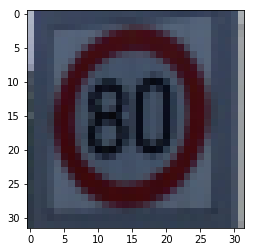

In [10]:
# Check image
plt.imshow(X_test_net[1])

In [11]:
# Check that lable match
y_test_net[1]

5

In [12]:
# normalize test images from internet
X_test_net_norm = normalize_image_set(X_test_net)

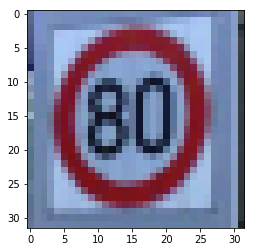

In [13]:
# Check normalization
plt.imshow(X_test_net_norm[1])

In [54]:
print(tf.train.get_checkpoint_state(os.path.dirname('inception_cpy')))

model_checkpoint_path: "inception_cpy"
all_model_checkpoint_paths: "inception_cpy"



In [76]:

with tf.Session() as sess:
    # Load best model and evaluate on iamges from internet
    #saver = tf.train.import_meta_graph('inception.meta')
    #saver.restore(sess, './inception')
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, './inception')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Training:",evaluate(X_train_mod, y_train_mod, 1.0))
    print("Validation:",evaluate(X_valid_norm, y_valid, 1.0))
    print("Test:",evaluate(X_test_norm, y_test, 1.0))
    print("Test Internet:",evaluate(X_test_net_norm, y_test_net, 1.0))

NotFoundError: Key beta1_power_1 not found in checkpoint
	 [[Node: save_1/RestoreV2_181 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_181/tensor_names, save_1/RestoreV2_181/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_178/_267 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_1480_save_1/RestoreV2_178", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save_1/RestoreV2_181', defined at:
  File "C:\Anaconda3\envs\carnd-term1\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\envs\carnd-term1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-73-48f866d3d3e1>", line 5, in <module>
    saver = tf.train.import_meta_graph('inception.meta')
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\training\saver.py", line 1577, in import_meta_graph
    **kwargs)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\meta_graph.py", line 498, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\importer.py", line 287, in import_graph_def
    op_def=op_def)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key beta1_power_1 not found in checkpoint
	 [[Node: save_1/RestoreV2_181 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_181/tensor_names, save_1/RestoreV2_181/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_178/_267 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_1480_save_1/RestoreV2_178", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [6]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 